In [1]:
from __future__ import print_function
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets, transforms 

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.MNIST("./data", train =True, download =True, transform= train_transforms)
test = datasets.MNIST("./data", train =False , download =True, transform= test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=8, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [5]:
dropout_value = 0.1
from model import Model_1
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_1().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

In [6]:
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [7]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss+=loss.item()
        
        loss.backward()
        optimizer.step()
        correct += GetCorrectPredCount(output, target)
        processed += len(data)
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))
    
    print('\nTrain set: Train loss: {:.4f}, Train Accuracy: {}/{} ({:.2f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [8]:
model = Model_1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


loss=0.11117184162139893 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:07<00:00, 66.83it/s]



Train set: Train loss: 185.0977, Train Accuracy: 54251/60000 (90.42%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0914, Accuracy: 9734/10000 (97.34%)

EPOCH: 1


loss=0.07110176235437393 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 68.78it/s]



Train set: Train loss: 39.4788, Train Accuracy: 58567/60000 (97.61%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0367, Accuracy: 9894/10000 (98.94%)

EPOCH: 2


loss=0.10078287124633789 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 69.17it/s]



Train set: Train loss: 29.7021, Train Accuracy: 58877/60000 (98.13%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0385, Accuracy: 9885/10000 (98.85%)

EPOCH: 3


loss=0.016802052035927773 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 67.55it/s]



Train set: Train loss: 25.7803, Train Accuracy: 59029/60000 (98.38%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9903/10000 (99.03%)

EPOCH: 4


loss=0.029384570196270943 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 68.23it/s]



Train set: Train loss: 22.3963, Train Accuracy: 59107/60000 (98.51%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


loss=0.016500381752848625 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 69.57it/s]



Train set: Train loss: 20.9866, Train Accuracy: 59175/60000 (98.62%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9926/10000 (99.26%)

EPOCH: 6


loss=0.04307078942656517 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:07<00:00, 66.33it/s]



Train set: Train loss: 19.9403, Train Accuracy: 59217/60000 (98.69%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


loss=0.007024940103292465 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 67.90it/s]



Train set: Train loss: 18.8936, Train Accuracy: 59261/60000 (98.77%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


loss=0.015380308963358402 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 67.89it/s]



Train set: Train loss: 17.7385, Train Accuracy: 59296/60000 (98.83%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


loss=0.08931303024291992 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 69.45it/s]



Train set: Train loss: 18.2128, Train Accuracy: 59279/60000 (98.80%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


loss=0.024778852239251137 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 70.03it/s]



Train set: Train loss: 16.8436, Train Accuracy: 59335/60000 (98.89%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9933/10000 (99.33%)

EPOCH: 11


loss=0.03775959461927414 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 68.66it/s]



Train set: Train loss: 15.8631, Train Accuracy: 59330/60000 (98.88%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


loss=0.029883451759815216 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 70.81it/s]



Train set: Train loss: 15.5548, Train Accuracy: 59356/60000 (98.93%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9941/10000 (99.41%)

EPOCH: 13


loss=0.0069421217776834965 batch_id=468: 100%|███████████████████████████████████████| 469/469 [00:07<00:00, 65.75it/s]



Train set: Train loss: 15.1923, Train Accuracy: 59380/60000 (98.97%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


loss=0.02167408913373947 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 68.89it/s]



Train set: Train loss: 14.9553, Train Accuracy: 59399/60000 (99.00%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 15


loss=0.062432799488306046 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 70.39it/s]



Train set: Train loss: 13.7172, Train Accuracy: 59458/60000 (99.10%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9926/10000 (99.26%)

EPOCH: 16


loss=0.013698793016374111 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:07<00:00, 66.78it/s]



Train set: Train loss: 14.3271, Train Accuracy: 59426/60000 (99.04%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


loss=0.03522365540266037 batch_id=468: 100%|█████████████████████████████████████████| 469/469 [00:06<00:00, 68.91it/s]



Train set: Train loss: 14.3446, Train Accuracy: 59433/60000 (99.06%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9937/10000 (99.37%)

EPOCH: 18


loss=0.014754205010831356 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 69.82it/s]



Train set: Train loss: 13.8435, Train Accuracy: 59440/60000 (99.07%)



  0%|                                                                                          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


loss=0.008484628982841969 batch_id=468: 100%|████████████████████████████████████████| 469/469 [00:06<00:00, 69.87it/s]



Train set: Train loss: 12.8402, Train Accuracy: 59473/60000 (99.12%)


Test set: Average loss: 0.0195, Accuracy: 9934/10000 (99.34%)



In [60]:
#t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Loss per epoch')

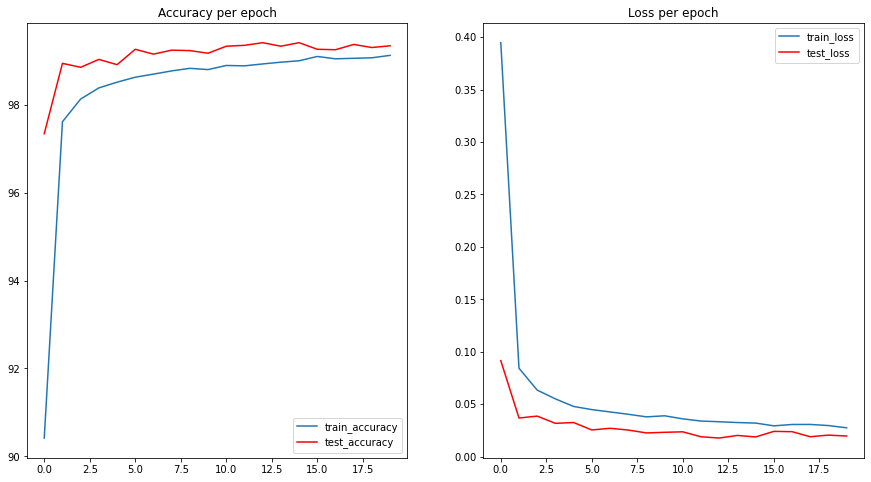

In [9]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

plt.subplot(1,2, 1)

plt.plot(np.array(train_acc))
plt.plot(np.array(test_acc), 'r')
plt.legend(["train_accuracy", "test_accuracy"])
plt.title("Accuracy per epoch")

plt.subplot(1,2,2)
plt.plot(train_losses)
plt.plot(test_losses, 'r')
plt.legend(["train_loss", "test_loss"])
plt.title("Loss per epoch")
     

## Inference 

### Target 
1. Get set up
   Get transforms, Data Loader, Basic Working codd, training and test lopp 
2. Results 
   Parameters : 10 k Parameters  
   Epoch 15 
   
   Training Acc: 99.13%
   Test Acc: 99.41%

3. Analysis 
   1. small  model (new_target)